In [1]:
%matplotlib inline

import sys
import os
sys.path.append("../..")
import inspect

import numpy as np
import re

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from skimage import exposure, img_as_float, morphology, color
from skimage.measure import label
from PIL import Image

from osgeo import gdal
import osr
import my_packages.My_Geoprocess as mgp
from sklearn.cluster import KMeans
from matplotlib import cm

from scipy import stats


In [3]:
ImagesFolder = '../../Poe/Images/Acolyte/S2A_MSIL1C_20180305T230901_N0206_R101_T58KEB_20180306T00234_bisAco/S2A_MSI_2018_03_05_23_09_01_T58KEB_L2R_tif/'
raster_wavelength = ['560']
raster_Name = ['rhos_' + f + '.tif' for f in raster_wavelength]
bands_data = []

for f in range(len(raster_Name)):
    raster_dataset = gdal.Open(ImagesFolder+raster_Name[f], gdal.GA_ReadOnly)
    band = raster_dataset.GetRasterBand(1)

geo_transform = raster_dataset.GetGeoTransform()
proj = raster_dataset.GetProjection()

rows, cols = (raster_dataset.RasterYSize, raster_dataset.RasterXSize)

WorkingIndex = np.full((10980, 10980), False)
WorkingIndex[5000:,0:8500] = True


Occurence of label  0 :  50778356
Occurence of label  1 :  51644

Occurence of label  0 :  50778356
Occurence of label  1 :  1094
Occurence of label  2 :  2226
Occurence of label  3 :  1595
Occurence of label  4 :  6807
Occurence of label  5 :  1040
Occurence of label  6 :  3488
Occurence of label  7 :  2870
Occurence of label  8 :  3831
Occurence of label  9 :  795
Occurence of label  10 :  5946
Occurence of label  11 :  2369
Occurence of label  12 :  1780
Occurence of label  13 :  544
Occurence of label  14 :  528
Occurence of label  15 :  2521
Occurence of label  16 :  2835
Occurence of label  17 :  102
Occurence of label  18 :  4858
Occurence of label  19 :  68
Occurence of label  20 :  3051
Occurence of label  21 :  164
Occurence of label  22 :  459
Occurence of label  23 :  2673


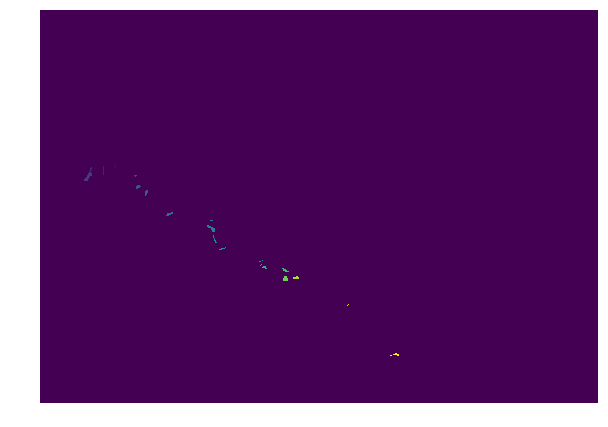

In [4]:
ShapeFolder = '../../Poe/Shapes/'
RoiPathName = 'BottomsSamp.shp'

labeled_pixels = mgp.create_mask_from_vector(ShapeFolder + RoiPathName,  cols, rows, geo_transform, proj, target_value=1, format=gdal.GDT_Byte)
labeled_pixels = labeled_pixels.GetRasterBand(1).ReadAsArray(xoff=0, yoff=5000, win_xsize=8500, win_ysize=5980).astype(bool)
labeled_Samples = label(labeled_pixels)

for i in np.unique(labeled_pixels):
    print('Occurence of label {0: d} : {1: d}'.format(i, np.sum(labeled_pixels == i)))
print('')
    
plt.figure(figsize=(10, 10))
plt.imshow(labeled_Samples)
plt.axis('off')

for i in np.unique(labeled_Samples):
    print('Occurence of label {0: d} : {1: d}'.format(i, np.sum(labeled_Samples == i)))
N_Samples = len(np.unique(labeled_Samples)) - 1

In [5]:
npzfile = np.load('../../Poe/CompressedData/XData.npz')
X = npzfile['VolumFreeR']

In [6]:
X.shape

(5980, 8500, 5)

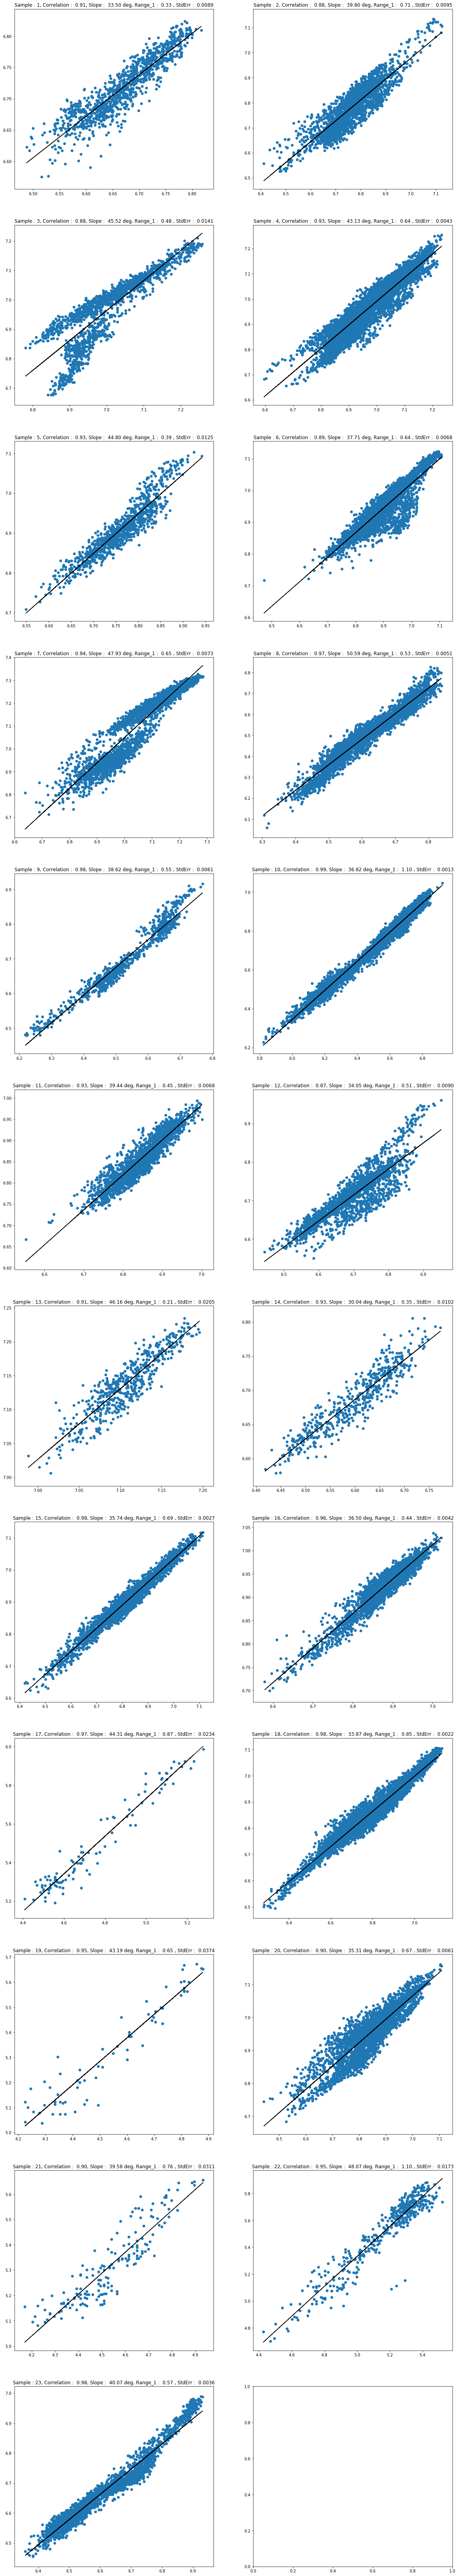

In [7]:
N_Samples = len(np.unique(labeled_Samples))-1 # without 0
classes_attributes = { 'names' : ['slope', 'intercept', 'r_value', 'p_value', 'std_err', 'range_1', 'range_2',]}

fig, axes = plt.subplots(int(np.ceil(N_Samples/2)),2, figsize=(20, int(np.ceil(N_Samples/2)*10)))
attributes_values = np.full((N_Samples, 5), np.nan)
for i, ax in enumerate(fig.axes):
    if i == N_Samples:
        continue
    x = np.log(6000.0*X[:,:,1][labeled_Samples==i+1])
    y = np.log(6000.0*X[:,:,2][labeled_Samples==i+1])
    ax.scatter(x,y)
    buffer = np.append(np.array(stats.linregress(x,y)[:]),np.array([np.max(x)-np.min(x) ,np.max(y)-np.min(y)]))
    ax.plot(x, x*buffer[0]+buffer[1], c='k')
    buffer[0] = 360.0*np.arctan(buffer[0])/(2.0*np.pi)
    classes_attributes[i+1] = buffer[:]
    ax.set_title('Sample : {0:d}, Correlation : {1: .2f}, Slope : {2: .2f} deg, Range_1 : {3: .2f} , StdErr : {4: .4f}'.format(i+1, *[classes_attributes[i+1][j] for j in [2 ,0 ,5 ,4]]))
    

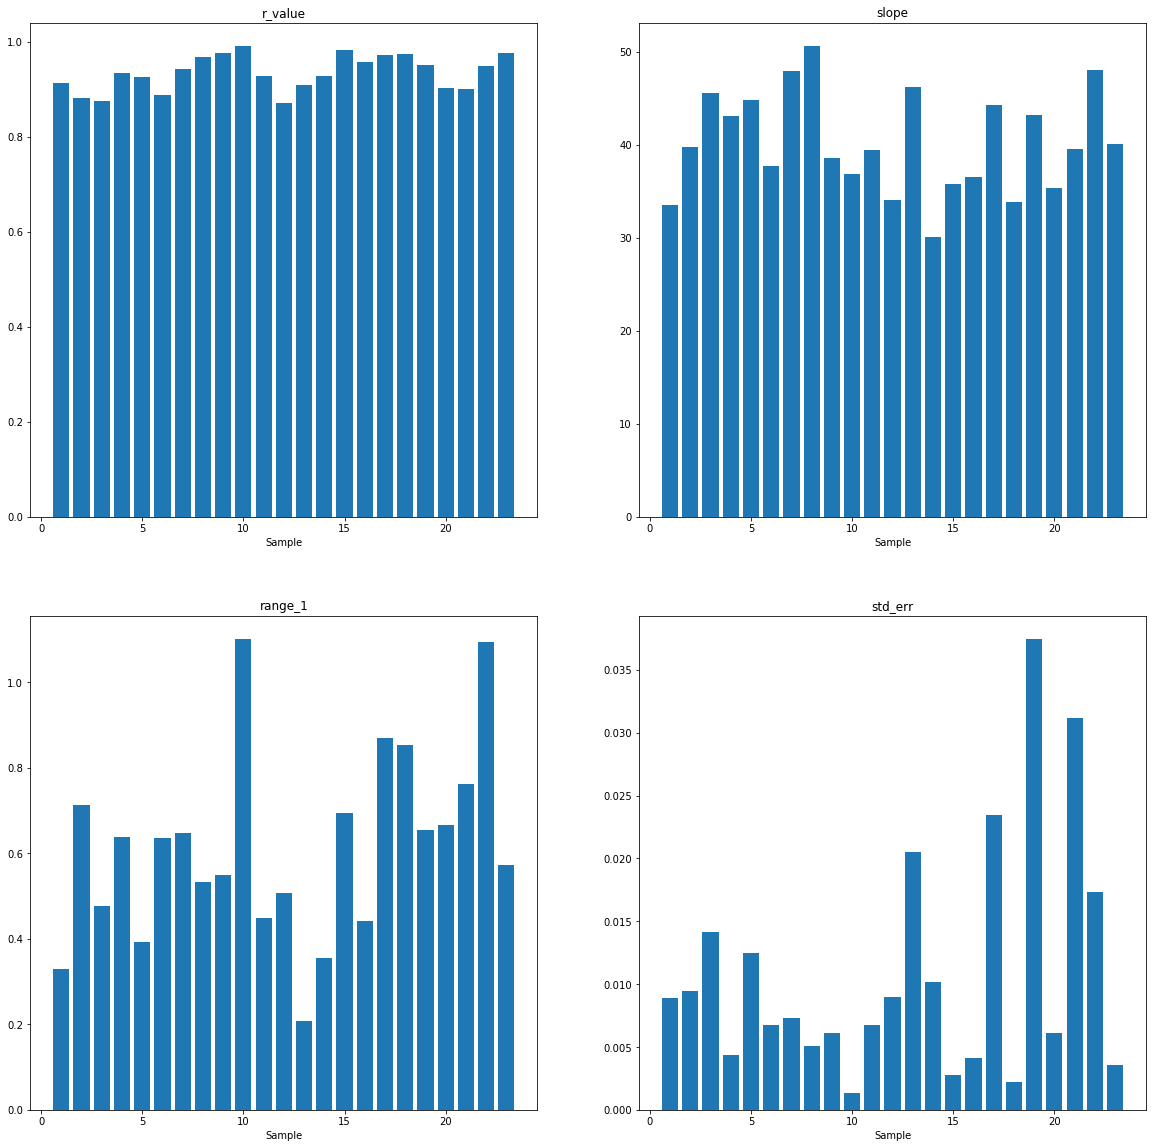

In [8]:
fig, axes = plt.subplots(2,2, figsize=(20, 20))
order = [2, 0, 5, 4]

for i, ax in enumerate(fig.axes):
    ax.bar(np.arange(1,N_Samples+1), [classes_attributes[j][order[i]] for j in range(1,N_Samples+1)])
    ax.set_title(classes_attributes['names'][order[i]])
    ax.set_xlabel('Sample')

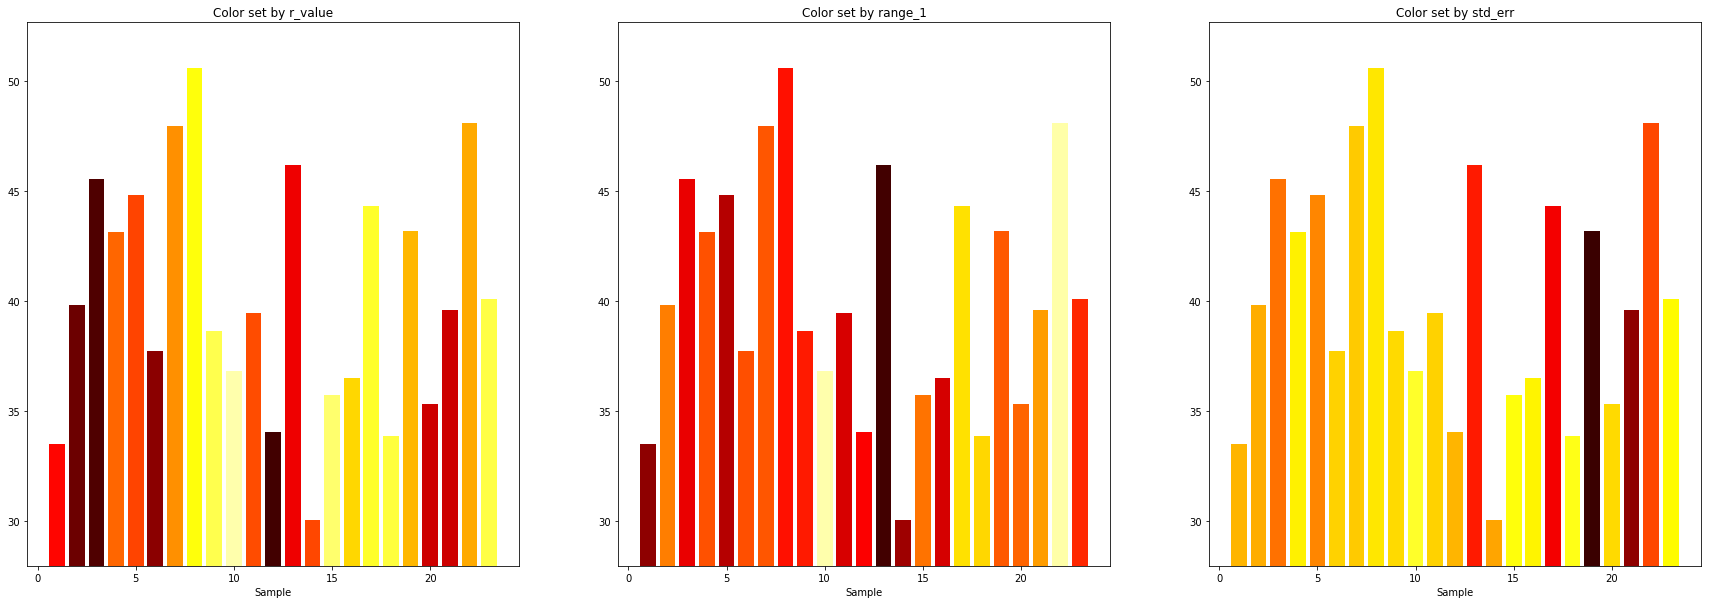

In [9]:
fig, axes = plt.subplots(1,3, figsize=(30, 10))
order = [2, 5, 4]
def getColor2(Listt, inverse=False, born=(0.1,0.1)):
    '''To DO: born param acte cheloument...'''
    Min = np.min(Listt)
    Max = np.max(Listt)
    Interval = float(Max - Min)
    Min = Min - (Interval * born[0])
    Max = Max + (Interval * born[1])
    if inverse:
        return cm.hot((1 - (Listt-Min) / float(Max-Min)))
    else:
        return  cm.hot((Listt-Min) / float(Max-Min))
    
def getRange(Listt):
    return np.max(Listt) - np.min(Listt)
    
InverseParam = [False, False, True]
BornParam = [(0.1,0.1),(0.1,0.1),(0.3,0.1)]

for i, ax in enumerate(fig.axes):
    param = [classes_attributes[j][order[i]] for j in range(1,N_Samples+1)]
    CC = getColor2(param, inverse=InverseParam[i], born=BornParam[i])
    Slopes =  [classes_attributes[j][0] for j in range(1,N_Samples+1)]
    ax.bar(np.arange(1,N_Samples+1), Slopes, color=CC)
    ax.set_title('Color set by '+classes_attributes['names'][order[i]])
    ax.set_xlabel('Sample')
    plot_yAdjust = getRange(Slopes)*0.1
    ax.set_ylim(np.max([np.min(Slopes)-plot_yAdjust, 0]), np.max(Slopes)+plot_yAdjust)

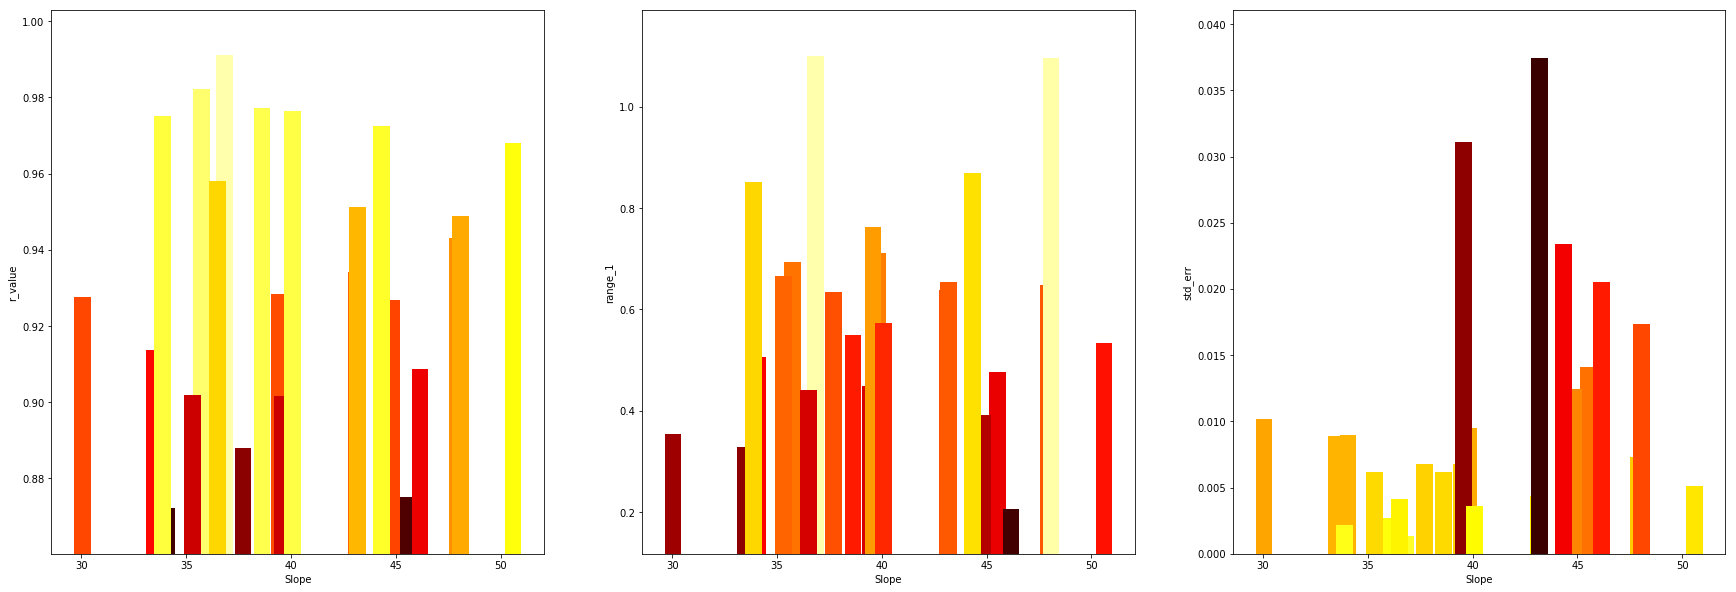

In [10]:
fig, axes = plt.subplots(1,3, figsize=(30, 10))
order = [2, 5, 4]
    
for i, ax in enumerate(fig.axes):
    param = [classes_attributes[j][order[i]] for j in range(1,N_Samples+1)]
    CC = getColor2(param, inverse=InverseParam[i], born=BornParam[i])
    Slopes =  [classes_attributes[j][0] for j in range(1,N_Samples+1)]
    ax.bar(Slopes, param, color=CC)
    ax.set_ylabel(classes_attributes['names'][order[i]])
    ax.set_xlabel('Slope')
    plot_yAdjust = getRange(param)*0.1
    ax.set_ylim(np.max([np.min(param)-plot_yAdjust, 0]), np.max(param)+plot_yAdjust)
    

In [11]:
Full_labeled = np.full((rows, cols), 0, dtype=np.int8)
Full_labeled[5000:,0:8500] = labeled_Samples
temporaryLayer = mgp.write_raster2('', Full_labeled, geo_transform, proj, DriverName="MEM", formatMem=gdal.GDT_Int16)

classes = np.unique(labeled_Samples)[1:]
NoDataValue = False
Output_File ='../Shapes/BottomSampStats.shp'

mgp.output_multipolygone_from_raster_layer(temporaryLayer,NoDataValue,classes,classes_attributes,Output_File)
temporaryLayer = None

Create a Vector Layer of 27 Features in Memory
Join classification based on values in field "class"
Create output file in ../Shapes/BottomSampStats.shp
 Set feature "slope" in output file
 Set feature "intercept" in output file
 Set feature "r_value" in output file
 Set feature "p_value" in output file
 Set feature "std_err" in output file
 Set feature "range_1" in output file
 Set feature "range_2" in output file
Field class == 1 : 2 features 
Field class == 2 : 1 features 
Field class == 3 : 2 features 
Field class == 4 : 1 features 
Field class == 5 : 1 features 
Field class == 6 : 1 features 
Field class == 7 : 1 features 
Field class == 8 : 1 features 
Field class == 9 : 1 features 
Field class == 10 : 1 features 
Field class == 11 : 2 features 
Field class == 12 : 1 features 
Field class == 13 : 1 features 
Field class == 14 : 1 features 
Field class == 15 : 1 features 
Field class == 16 : 1 features 
Field class == 17 : 1 features 
Field class == 18 : 1 features 
Field class == 

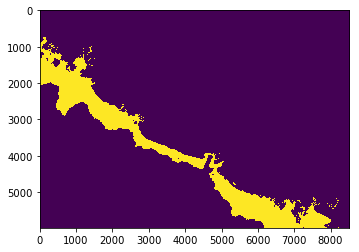

In [12]:
ShapeFolder = '../../Poe/Shapes/'
Lagoon = 'Mask/Lagoon.tif'

ClassifyIndex = gdal.Open(ImagesFolder + Lagoon, gdal.GA_ReadOnly)
ClassifyIndex = ClassifyIndex.GetRasterBand(1).ReadAsArray(xoff=0, yoff=5000, win_xsize=8500, win_ysize=5980).astype(bool)

plt.imshow(ClassifyIndex)

In [13]:
Band = ['ExtraBlue', 'Blue', 'Green', 'Red', 'ExtraRed']
Sample_id = 10
ErMap = npzfile['ErMap'] # Define negative values or soil/deep_ocean values inside cropped area
data = {}
for i in range(X.shape[2]-1,-1,-1):
    for i2 in range(i-1,-1,-1):

        I = np.log(X[:,:,i][labeled_Samples==Sample_id])
        J = np.log(X[:,:,i2][labeled_Samples==Sample_id])
        index = np.logical_and(~ErMap[:,:,i], ~ErMap[:,:,i2])
        index = np.logical_and(index, ClassifyIndex)
        data[Band[i], Band[i2]] = np.full(index.shape, np.nan)
        data[Band[i], Band[i2]][index] = mgp.get_dij_map(np.log(X[:,:,i][index]), np.log(X[:,:,i2][index]), I, J)
        #data[Band[i], Band[i2]][np.logical_or(np.logical_or(ErMap[:,:,i], ErMap[:,:,i2]), ~ClassifyIndex)] = np.nan
        data[Band[i], Band[i2]] = np.dstack((data[Band[i], Band[i2]], ErMap[:,:,i], ErMap[:,:,i2]))
del index      

In [14]:
RGB_wavelength = ['665','560','492']
RGB_Name = ['rhos_' + f + '.tif' for f in RGB_wavelength]
bands_data = []

for f in range(len(RGB_Name)):
    raster_dataset = gdal.Open(ImagesFolder+RGB_Name[f], gdal.GA_ReadOnly)
    for b in range(1, raster_dataset.RasterCount+1):
        band = raster_dataset.GetRasterBand(b)
        bands_data.append(band.ReadAsArray(xoff=0, yoff=5000, win_xsize=8500, win_ysize=5980))

bands_data = np.dstack(bands_data)

data['colorspace','HSV_H'] =  color.rgb2hsv(img_as_float(bands_data))
del bands_data

In [15]:
GlobalClassifIndex = np.logical_and(np.sum(ErMap, axis=2)==0, ClassifyIndex)
TX = []
for i in data.keys():
    TX.append(data[i][:,:,0][GlobalClassifIndex])

TX = np.stack(TX,axis=1)
assert TX.shape[0] == np.sum(GlobalClassifIndex)
assert np.sum(np.isnan(TX)) == 0
print(np.sum(np.isnan(TX)))

0


In [16]:
np.savez('../../Poe/CompressedData/TrainMatrix.npz', Train=TX, CroppedIndex=GlobalClassifIndex)

In [17]:
GlobalClassifIndex.shape

(5980, 8500)